In [1]:
root = 'C://Users//Ionut Halmagiu//PycharmProjects//pythonProject4//Circuit Recognition.v6-main-dataset.voc//train'

# we have four labels
labels = ['background', 'r', 'i', 'v', 'acv', 'l', 'c', 'l-']
label2targets = {l: t for t, l in enumerate(labels)}
targets2label = {t: l for l, t in label2targets.items()}
num_classes = len(targets2label)

In [2]:
print(num_classes)

8


In [3]:
def plot_img_bbox(img, target, labels=None, scores=None):
    fig, a = plt.subplots(1, 1)
    fig.set_size_inches(5, 5)
    a.imshow(img)

    for i, box in enumerate(target):
        x, y, width, height = box[0], box[1], box[2] - box[0], box[3] - box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth=2,
                                 edgecolor='r',
                                 facecolor='none')
        a.add_patch(rect)

        if labels is not None and scores is not None:
            label = labels[i]
            score = scores[i]
            text = f"{label}: {score:.2f}"
            a.text(x, y, text, color='r', verticalalignment='bottom', bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 1})

    plt.show()

In [4]:
!pip install -q torch_snippets lovely-tensors torchinfo

from torch_snippets import *
from IPython import display
import matplotlib.pyplot as plt
import matplotlib.patches as patches
display.set_matplotlib_formats('svg')

from torchinfo import summary

import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from xml.etree import ElementTree as et
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

C:\Users\Ionut Halmagiu\AppData\Local\Temp\ipykernel_11424\1416548394.py:7: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


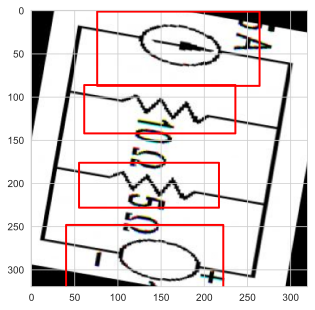

In [5]:
def preprocess_img(img):
    img = torch.tensor(img).permute(2, 0 ,1)
    return img.float()

class ComponentDataset(Dataset):
    def __init__(self, root=root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.img_paths = sorted(Glob(self.root + '/*.jpg'))
        self.xlm_paths = sorted(Glob(self.root + '/*.xml'))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        w, h = 320, 320
        img_path = self.img_paths[idx]
        xlm_path = self.xlm_paths[idx]
        img = Image.open(img_path).convert('RGB')
        W, H = img.size
        img = np.array(img.resize((w, h),
                       resample=Image.Resampling.BILINEAR))/255.
        xlm = et.parse(xlm_path)
        objects = xlm.findall('object')
        labels = []
        boxes = []
        for obj in objects:
            label = obj.find('name').text
            labels.append(label)
            XMin = float(obj.find('bndbox').find('xmin').text)
            YMin = float(obj.find('bndbox').find('ymin').text)
            XMax = float(obj.find('bndbox').find('xmax').text)
            YMax = float(obj.find('bndbox').find('ymax').text)
            bbox = [XMin / W, YMin / H, XMax / W, YMax / H]
            bbox = (bbox * np.array([w, h, w, h])).astype(np.int16).tolist()
            boxes.append(bbox)
        target = {}
        target['labels'] = torch.tensor([label2targets[label] for label in labels]).long()
        target['boxes'] = torch.tensor(boxes).float()
        img = preprocess_img(img)
        return img, target

    def collate_fn(self, batch):
        return tuple(zip(*batch))

val_root = 'C://Users//Ionut Halmagiu//PycharmProjects//pythonProject4//Circuit Recognition.v6-main-dataset.voc//test'

train_ds = ComponentDataset()
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True, collate_fn=train_ds.collate_fn)

val_ds = ComponentDataset(root=val_root)
val_dl = DataLoader(val_ds, batch_size=2, shuffle=True, collate_fn=val_ds.collate_fn)

img, target = train_ds[10]
plot_img_bbox(img.permute(1,2,0), target['boxes'])  

# Model evaluation 🤖

In [6]:
def get_model():
    model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    #print(in_features)
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

# test the model
imgs, targets = next(iter(train_dl))
imgs = list(img.to(device) for img in imgs)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

model = get_model().to(device)
print(model(imgs, targets))
summary(model, (1,3,320,320))

C:\Users\Ionut Halmagiu\PycharmProjects\pythonProject4\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter '{'weights': ('pretrained', FasterRCNN_ResNet50_FPN_Weights.COCO_V1), 'weights_backbone': ('pretrained_backbone', ResNet50_Weights.IMAGENET1K_V1)}' is deprecated since 0.13 and may be removed in the future, please use '{'weights': ('pretrained', FasterRCNN_ResNet50_FPN_Weights.COCO_V1), 'weights_backbone': ('pretrained_backbone', ResNet50_Weights.IMAGENET1K_V1)}' instead.
  warnings.warn(
C:\Users\Ionut Halmagiu\PycharmProjects\pythonProject4\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


{
    'loss_classifier': tensor grad NllLossBackward0 1.931,
    'loss_box_reg': tensor grad DivBackward0 0.162,
    'loss_objectness': tensor grad BinaryCrossEntropyWithLogitsBackward0 1.405,
    'loss_rpn_box_reg': tensor grad DivBackward0 0.093
}

Layer (type:depth-idx)                                  Output Shape              Param #
FasterRCNN                                              [100, 4]                  --
├─GeneralizedRCNNTransform: 1-1                         [1, 3, 800, 800]          --
├─BackboneWithFPN: 1-2                                  [1, 256, 13, 13]          --
│    └─IntermediateLayerGetter: 2-1                     [1, 2048, 25, 25]         --
│    │    └─Conv2d: 3-1                                 [1, 64, 400, 400]         (9,408)
│    │    └─FrozenBatchNorm2d: 3-2                      [1, 64, 400, 400]         --
│    │    └─ReLU: 3-3                                   [1, 64, 400, 400]         --
│    │    └─MaxPool2d: 3-4                              [1, 64, 200, 200]         --
│    │    └─Sequential: 3-5                             [1, 256, 200, 200]        (212,992)
│    │    └─Sequential: 3-6                             [1, 512, 100, 100]        1,212,416
│    │    └─Sequential: 3-7              

EPOCH: 0.001  trn_loss: 4.470  trn_loc_loss: 2.937  trn_regr_loss: 0.237  trn_loss_objectness: 1.229  trn_loss_rpn_box_reg: 0.067  (18.67s - 29145.82s remaining)
EPOCH: 0.003  trn_loss: 2.131  trn_loc_loss: 1.314  trn_regr_loss: 0.668  trn_loss_objectness: 0.101  trn_loss_rpn_box_reg: 0.048  (38.23s - 29817.68s remaining)
EPOCH: 0.004  trn_loss: 1.470  trn_loc_loss: 0.732  trn_regr_loss: 0.642  trn_loss_objectness: 0.058  trn_loss_rpn_box_reg: 0.038  (57.61s - 29938.29s remaining)
EPOCH: 0.005  trn_loss: 1.328  trn_loc_loss: 0.614  trn_regr_loss: 0.540  trn_loss_objectness: 0.113  trn_loss_rpn_box_reg: 0.061  (78.52s - 30584.42s remaining)
EPOCH: 0.006  trn_loss: 1.910  trn_loc_loss: 0.981  trn_regr_loss: 0.773  trn_loss_objectness: 0.102  trn_loss_rpn_box_reg: 0.054  (101.38s - 31570.93s remaining)
EPOCH: 0.008  trn_loss: 1.770  trn_loc_loss: 0.867  trn_regr_loss: 0.783  trn_loss_objectness: 0.088  trn_loss_rpn_box_reg: 0.032  (133.42s - 34599.13s remaining)
EPOCH: 0.009  trn_loss: 1.

100%|██████████| 103/103 [00:00<00:00, 1355.65it/s]


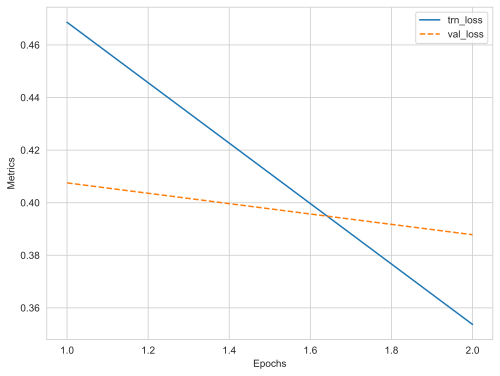

In [14]:
def train_batch(batch, model, optim):
    model.train()
    imgs, targets = batch
    imgs = list(img.to(device) for img in imgs)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optim.zero_grad()
    losses = model(imgs, targets)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optim.step()
    return loss, losses

@torch.no_grad()
def validate_batch(batch, model, optim):
    model.train()
    imgs, targets = batch
    imgs = list(img.to(device) for img in imgs)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optim.zero_grad()
    losses = model(imgs, targets)
    loss = sum(loss for loss in losses.values())
    return loss, losses

model = get_model().to(device)
optim = torch.optim.SGD(model.parameters(), lr=0.005,
                       weight_decay=5e-4, momentum=0.9)

n_epochs =2
log = Report(n_epochs)
for e in range(n_epochs):
    for i, batch in enumerate(train_dl):
        N = len(train_dl)
        loss, losses = train_batch(batch, model, optim)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = [losses[k] for k in
                                                                  ['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg']]
        log.record(e + (i+1)/N, trn_loss=loss.item(), trn_loc_loss=loc_loss.item(),
                   trn_regr_loss=regr_loss.item(), trn_loss_objectness=loss_objectness.item(),
                   trn_loss_rpn_box_reg = loss_rpn_box_reg.item())
    for i, batch in enumerate(val_dl):
        N = len(val_dl)
        loss, losses = validate_batch(batch, model, optim)  # Removed `.float()` here
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = [losses[k] for k in
                                                                  ['loss_classifier', 'loss_box_reg',
                                                                   'loss_objectness', 'loss_rpn_box_reg']]
        log.record(e + (i+1)/N, val_loss=loss.item(), val_loc_loss=loc_loss.item(),
                   val_regr_loss=regr_loss.item(), val_loss_objectness=loss_objectness.item(),
                   val_loss_rpn_box_reg = loss_rpn_box_reg.item())
    log.report_avgs(e+1)

log.plot_epochs(['trn_loss', 'val_loss'])

# Model Testing ⚡

In [24]:
model = get_model().to(device)

# Load the saved model's weights
model.load_state_dict(torch.load('C:\\Users\\Ionut Halmagiu\\PycharmProjects\\pythonProject4\\saved_models\\default-FASTER.pth'))


<All keys matched successfully>

In [ ]:
def save_model(model, filepath):
    """
    Save the model's state dictionary to a file.

    Args:
        model (nn.Module): The model to be saved.
        filepath (str): Path to the file where the model should be saved.
    """
    torch.save(model.state_dict(), filepath)
    print(f"Model saved to {filepath}")

In [ ]:
save_model(model, 'C:\\Users\\Ionut Halmagiu\\PycharmProjects\\pythonProject4\\saved_models\\default-FASTER.pth')


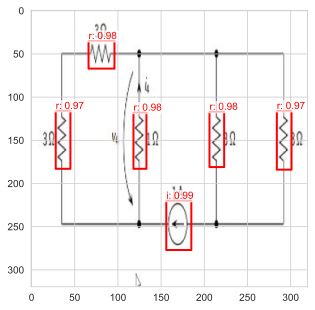

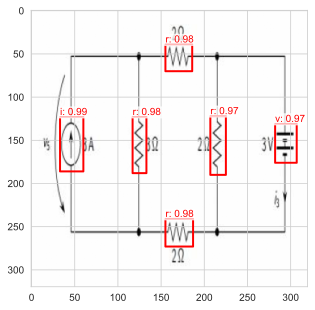

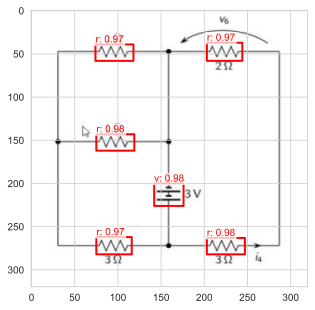

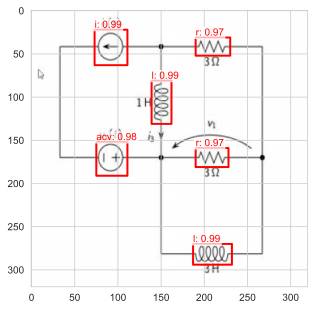

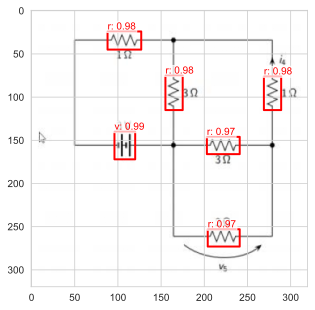

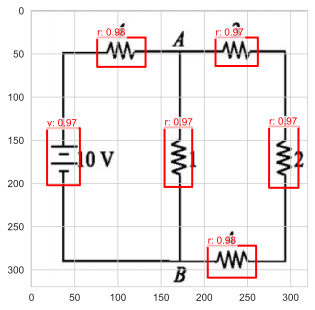

In [25]:


from torchvision.ops import nms

def decode_output(output):
    bbs = output['boxes'].cpu().detach().numpy().astype(np.uint16)
    labels = np.array([targets2label[i] for i in output['labels'].cpu().detach().numpy()])
    confs = output['scores'].cpu().detach().numpy()
    idxs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    bbs, confs, labels = [tensor[idxs] for tensor in [bbs, confs, labels]]
    if len(idxs) == 1:
        bbs, confs, labels = [np.array([tensor]) for tensor in [bbs, confs, labels]]
    return bbs.tolist(), confs.tolist(), labels.tolist()

model.eval()
for i, (images, targets) in enumerate(val_dl):
    imgs = list(img.to(device) for img in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    if i == 3:
        break
    images = [im for im in imgs]
    outputs = model(images)
    for i, output in enumerate(outputs):
        bbs, confs, labels = decode_output(output)
        plot_img_bbox(images[i].cpu().permute(1, 2, 0), bbs, labels, confs)









Processing Image: N/A

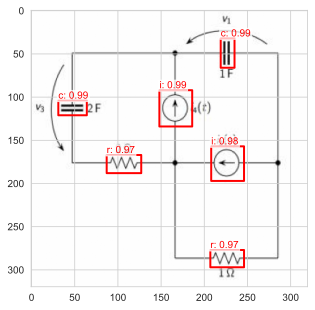

In [54]:
def decode_output(output):
    bbs = output['boxes'].cpu().detach().numpy().astype(np.uint16)
    labels = np.array([targets2label[i] for i in output['labels'].cpu().detach().numpy()])
    confs = output['scores'].cpu().detach().numpy()
    idxs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    bbs, confs, labels = [tensor[idxs] for tensor in [bbs, confs, labels]]
    if len(idxs) == 1:
        bbs, confs, labels = [np.array([tensor]) for tensor in [bbs, confs, labels]]
    return bbs.tolist(), confs.tolist(), labels.tolist()

image_index_to_test = 0  # Change this to the desired index

model.eval()

for i, (images, targets) in enumerate(val_dl):
    if i == image_index_to_test:
        imgs = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Process only the specified image
        img_to_test = imgs[image_index_to_test]
        target_to_test = targets[image_index_to_test]
        
        # Print the name of the image being processed
        print("Processing Image:", target_to_test.get("image_path", "N/A"))

        outputs = model([img_to_test])

        for i, output in enumerate(outputs):
            bbs, confs, labels = decode_output(output)
            plot_img_bbox(img_to_test.cpu().permute(1, 2, 0), bbs, labels, confs)
        break